# Generative Models

## VAE

By Alireza Heidari

In this notebook, we are going to implement Variational AutoEncoder (VAE) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each generative model.

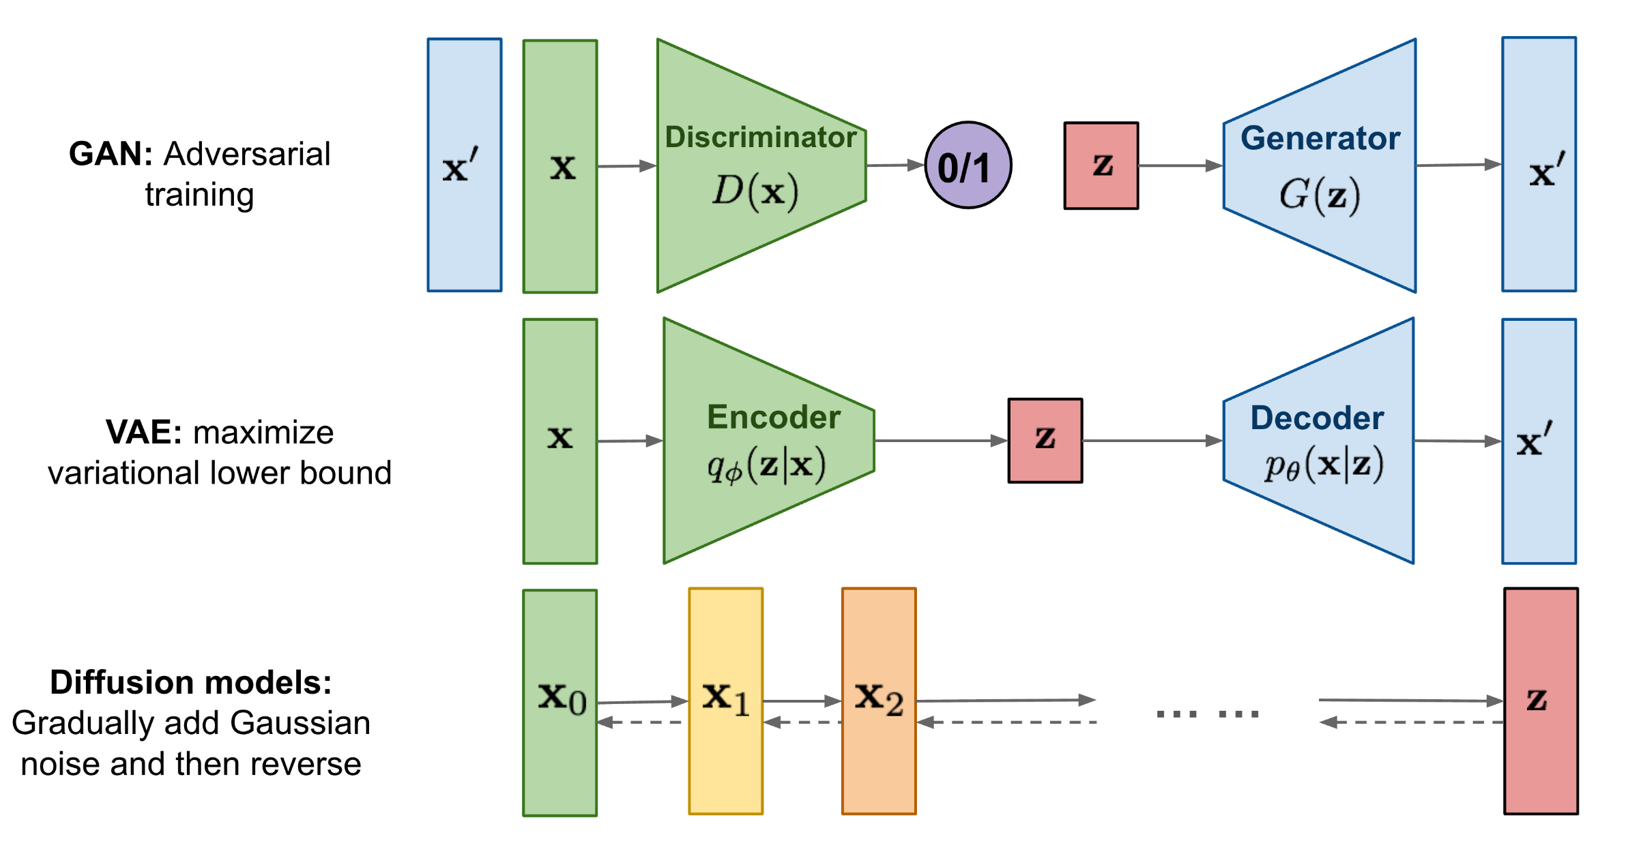

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images.

### Initialization

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from tqdm import tqdm

BATCH_SIZE = 20
IMG_SIZE = 32 
C_IN = 1 # Number of input channels

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [2]:
DEVICE

'cuda'

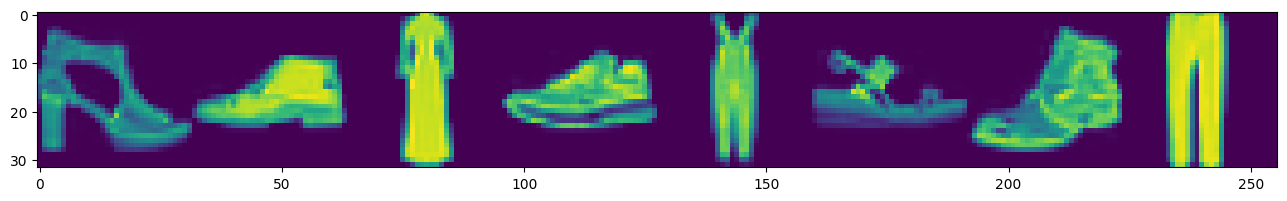

In [3]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

### VAE

VAE is a generative model consisting of an encoder network and a decoder network. The encoder maps the input data into a latent space, where the data is represented by probability distributions. A decoder network generates the output data from samples of the latent space.

VAE is trained using a variational inference approach, where the goal is to maximize the evidence lower bound (ELBO) of the log-likelihood of the data. The ELBO consists of two terms: the reconstruction loss, which measures how well the decoder can reconstruct the input data from the latent space, and the KL divergence between the prior (considered Gaussian) and posterior distributions over the latent space. The posterior distribution is usually considered Gaussian, and the encoder only tries to learn its mean and variance. Given the mean and the variance, one can use the reparameterization trick to sample from the encoder.

### ❓ **Question**

+ **What is the reparameterization trick? How does it affect the sampling and the gradient backpropagation processes**?  

The reparameterization trick is a technique used in Variational Autoencoders (VAEs) to allow for end-to-end gradient-based optimization.

Without the reparameterization trick, VAEs sample from the latent space using the latent means and variances from the encoder. However, since sampling is a non-differentiable operation, the gradients cannot flow back through the sampling process to the encoder.

The reparameterization trick solves this by reparameterizing the sampling process in a differentiable manner. Instead of direct sampling, it uses the latent means and variances to determine a transformation of a unit Gaussian noise vector. That is, instead of:

z = sample(mean, var)

It uses:

z = mean + var * epsilon

Where epsilon is a unit Gaussian noise vector.

Now, the latent vector z is expressed as a differentiable transformation of the noise epsilon. Therefore, gradients can flow back

+ **What are the advantages of VAEs over regular Autoencoders**?

Below are the most important advantages:

- Regular autoencoders are deterministic, they map the input to a single latent representation. VAEs model the latent space probabilistically by learning a distribution over the latent variables. This allows for variability and uncertainty in the latent representations.

- VAEs have a regularizer in the form of the KL divergence term. This encourages the latent space to be smooth and continuous, avoiding holes or clusters. Regular autoencoders have no such regularizer on the latent space.

- The probabilistic latent space of VAEs allows us to generate new samples by sampling from the learned distribution and decoding them. Regular autoencoders do not model a distribution, so they cannot generate new samples in the same way.

- VAEs can learn a lower dimensional latent space in a more robust way. The regularizer prevents the model from arbitrarily mapping all inputs to a single point, which can happen in regular autoencoders.

- VAEs are more robust to noisy input data due to the probabilistic nature of the latent space representation. Even with incomplete or corrupted input, VAEs can often generate meaningful outputs but autoencoders often do not because they just concentrate on the reconstruction loss. 

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.fc1 = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.BatchNorm1d(self.hidden_dim // 2),
            nn.ReLU(),
        )
        
        self.fc2_mean = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim // 2, latent_dim)

    def forward(self, x):
        h = self.fc1(x)

        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        z = mean + eps * std
        return z, mean, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh(),
        )

    def forward(self, z):
        h = self.fc(z)
        return h


class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        z, _, _ = self.encoder(x)
        return self.decoder(z)

### Training

In [5]:
class VAEManager():
    def __init__(self, input_dim, hidden_dim, latent_dim, lr):

        self.vae = VariationalAutoEncoder(input_dim, hidden_dim, latent_dim).to(DEVICE)
        self.optimizer = torch.optim.Adam(self.vae.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        self.loss = nn.MSELoss(reduction='sum')
        
    def train(self, dataloader, epochs):
        history = dict(loss=[])
        for epoch in range(epochs):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.squeeze(1).view(BATCH_SIZE, -1).to(DEVICE)
                z, mean, logvar = self.vae.encoder(batch_x)
                reconstructed = self.vae.decoder(z)
                reconstruction_loss =self.loss(reconstructed, batch_x)
                kl_loss = 0.5 * torch.sum(-1 - logvar + mean.pow(2) + logvar.exp())
                loss = reconstruction_loss + kl_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss.append(loss.item() / batch_x.size(0))

            mean_loss = np.mean(total_loss) 
            self.scheduler.step(mean_loss)
            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, epochs, mean_loss)
            )
            self.sample(8, plot=True)
            history['loss'].append(mean_loss)

        return history
    

    def sample(self, n, plot=True):
        z1 = torch.randn(1, self.vae.latent_dim).to(DEVICE)
        z2 = torch.randn(1, self.vae.latent_dim).to(DEVICE)
        zs = torch.zeros((n, self.vae.latent_dim)).to(DEVICE)
        for i in range(n):
            alpha = i / (n - 1)
            zs[i] = (1-alpha) * z1 + alpha * z2
        with torch.no_grad():
            images = torch.cat([self.vae.decoder(z) for z in zs], dim=0).view(n, 1 , 32, 32).detach()
            if plot:
                plot_images(images)
            return images

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 107.96it/s]


[Epoch: 1/40] [loss: 164.1407]


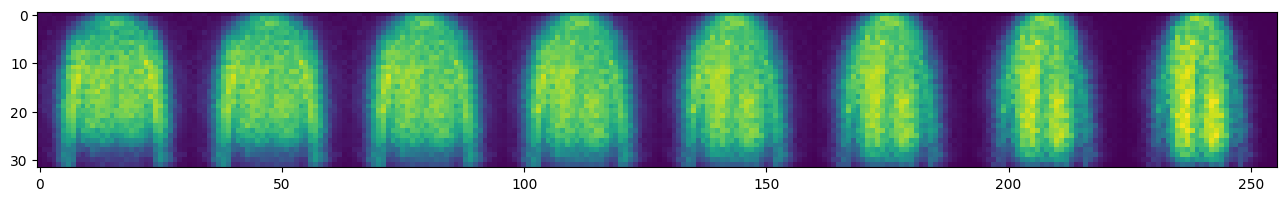

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 104.13it/s]


[Epoch: 2/40] [loss: 108.0085]


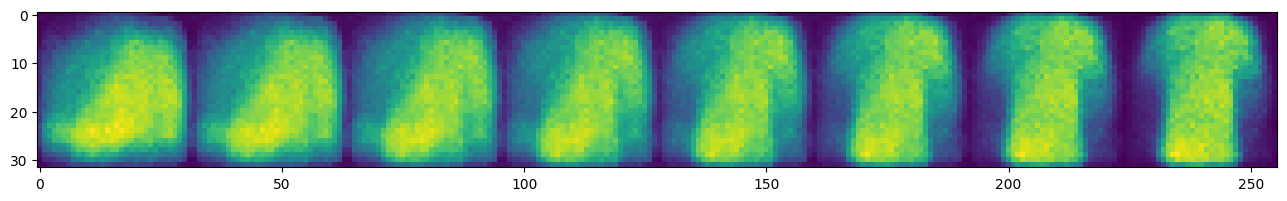

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 101.43it/s]


[Epoch: 3/40] [loss: 98.9994]


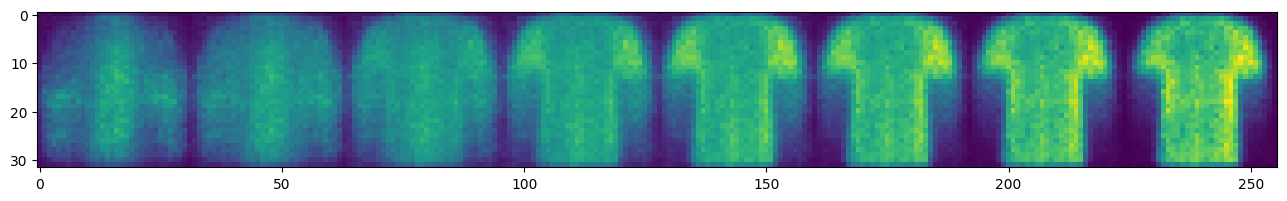

100%|█████████████████████████████████████████| 937/937 [00:09<00:00, 99.67it/s]


[Epoch: 4/40] [loss: 92.4220]


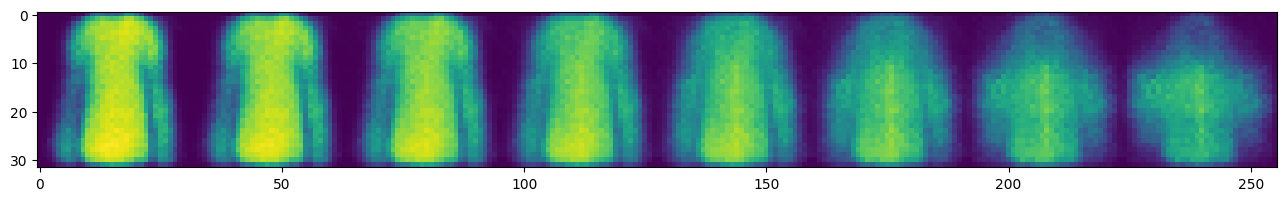

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 100.40it/s]

[Epoch: 5/40] [loss: 86.5752]


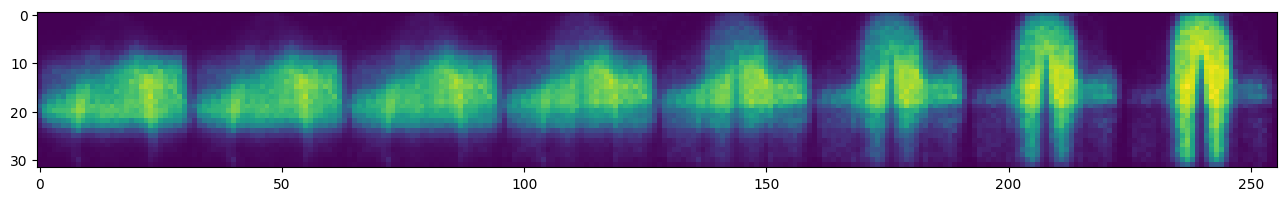

100%|█████████████████████████████████████████| 937/937 [00:09<00:00, 99.91it/s]


[Epoch: 6/40] [loss: 82.2083]


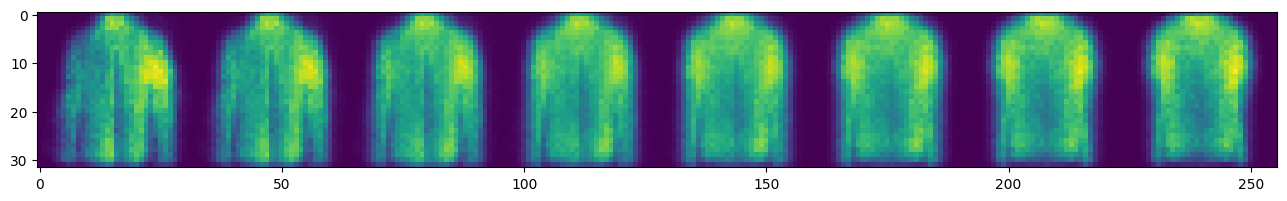

100%|█████████████████████████████████████████| 937/937 [00:09<00:00, 98.95it/s]


[Epoch: 7/40] [loss: 78.5534]


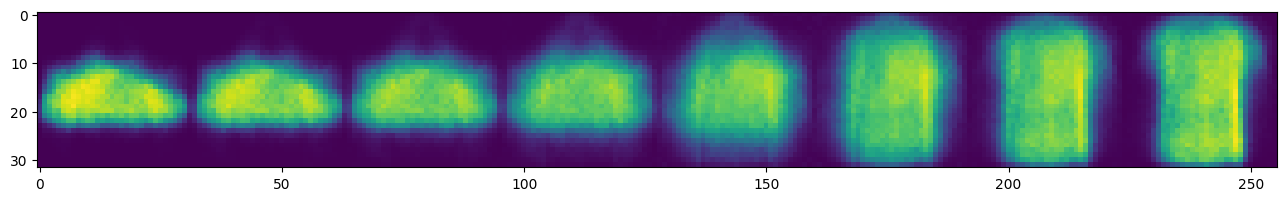

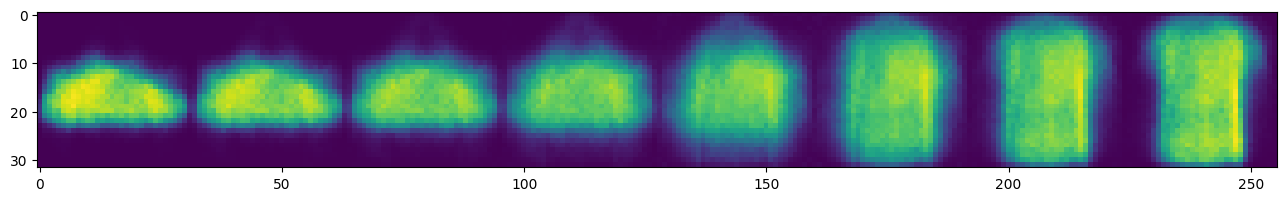

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 101.83it/s]


[Epoch: 8/40] [loss: 75.6200]


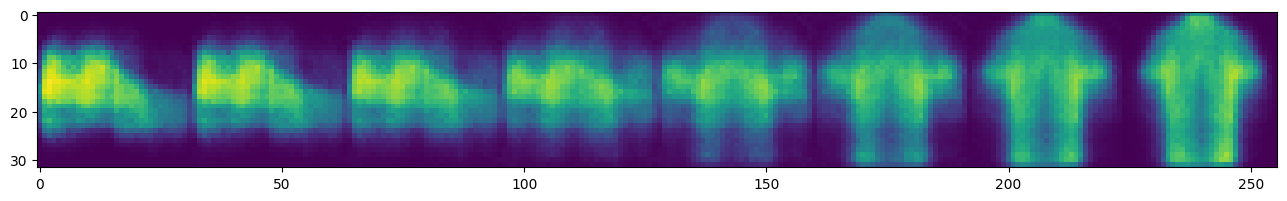

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 101.36it/s]


[Epoch: 9/40] [loss: 73.3655]


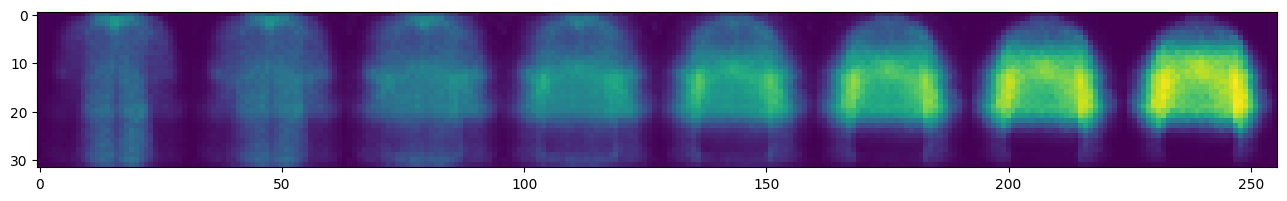

100%|█████████████████████████████████████████| 937/937 [00:09<00:00, 99.43it/s]

[Epoch: 10/40] [loss: 71.4465]


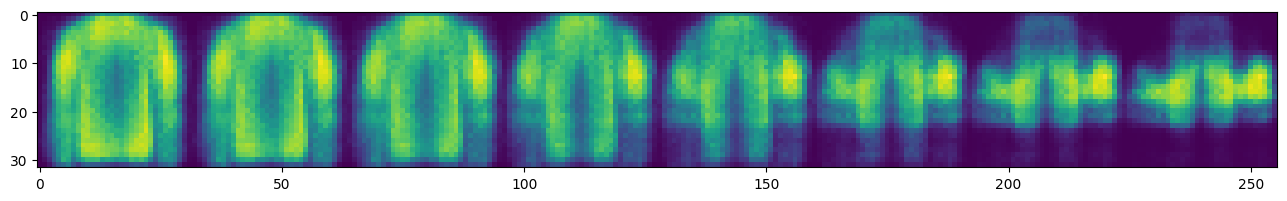

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 103.66it/s]


[Epoch: 11/40] [loss: 69.8101]


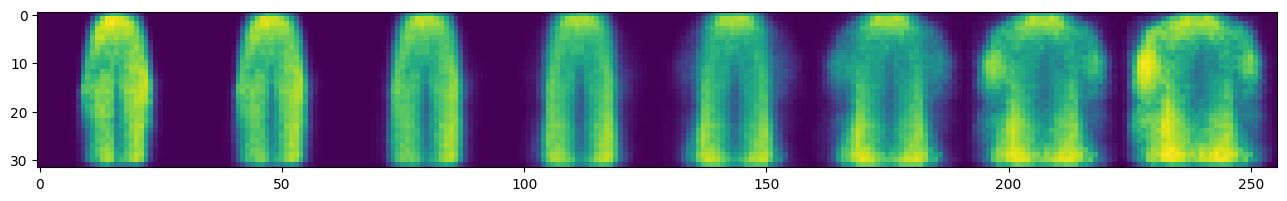

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 102.81it/s]

[Epoch: 12/40] [loss: 68.6542]


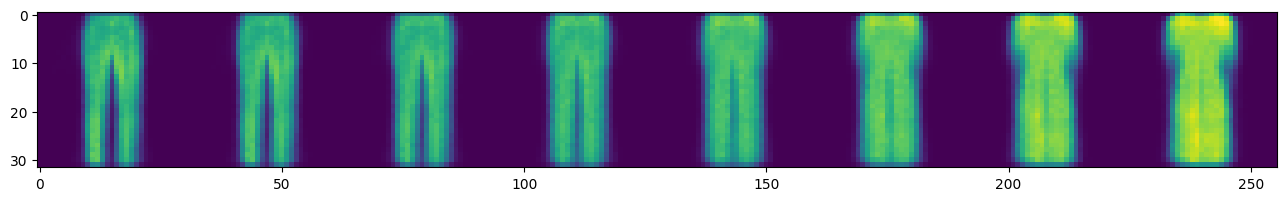

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 106.71it/s]


[Epoch: 13/40] [loss: 67.5906]


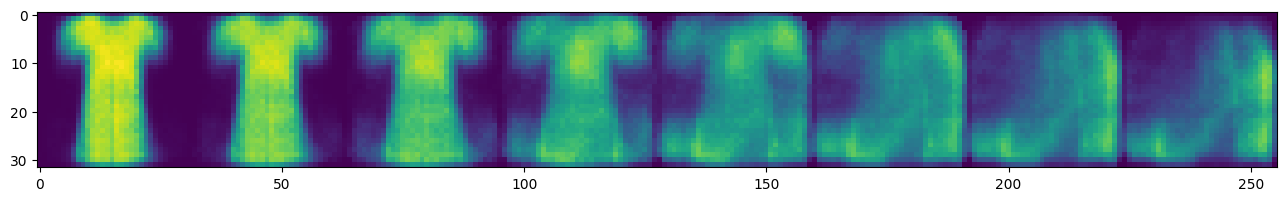

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 101.85it/s]

[Epoch: 14/40] [loss: 66.7220]


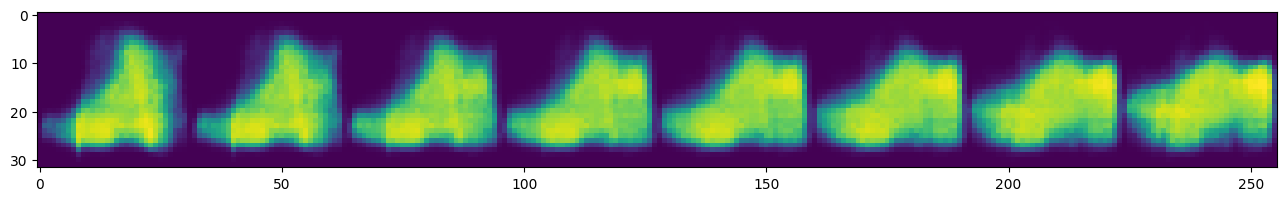

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 102.89it/s]


[Epoch: 15/40] [loss: 65.9217]


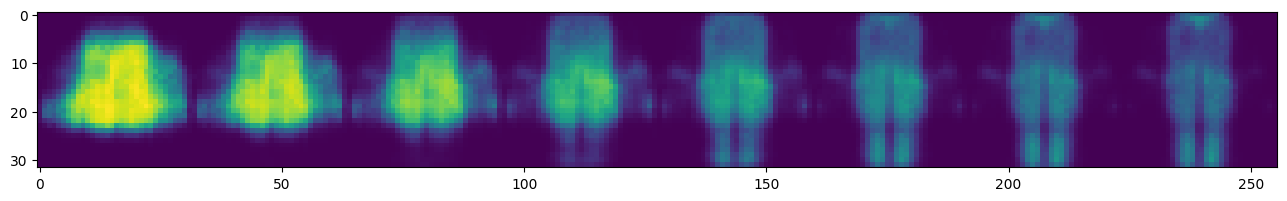

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 101.83it/s]

[Epoch: 16/40] [loss: 65.1620]


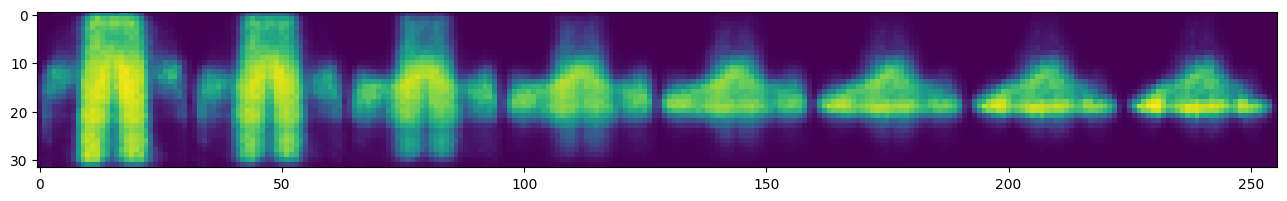

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 100.37it/s]


[Epoch: 17/40] [loss: 64.8952]


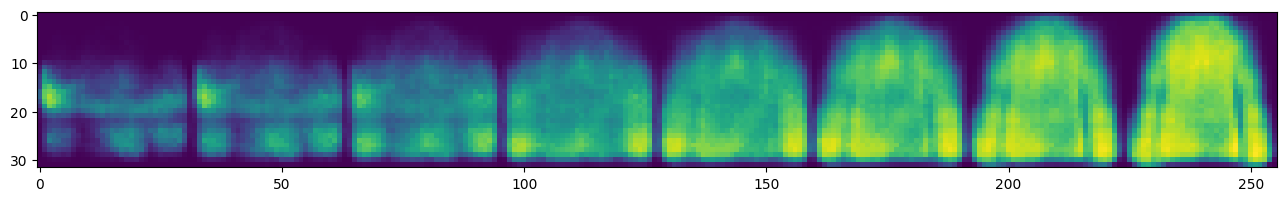

100%|█████████████████████████████████████████| 937/937 [00:09<00:00, 98.55it/s]


[Epoch: 18/40] [loss: 64.3145]


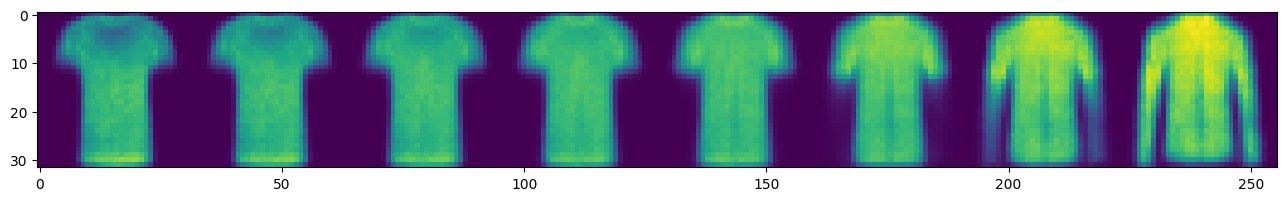

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 100.82it/s]


[Epoch: 19/40] [loss: 63.9008]


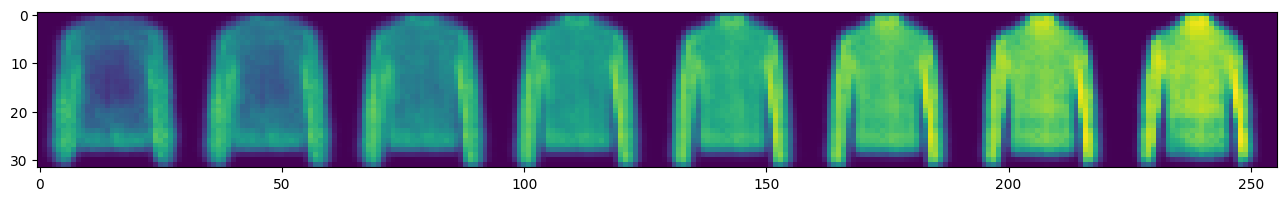

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 104.61it/s]


[Epoch: 20/40] [loss: 63.5564]


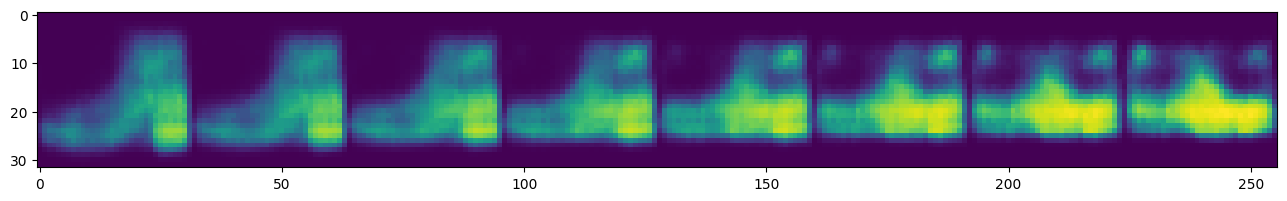

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 106.89it/s]


[Epoch: 21/40] [loss: 63.2037]


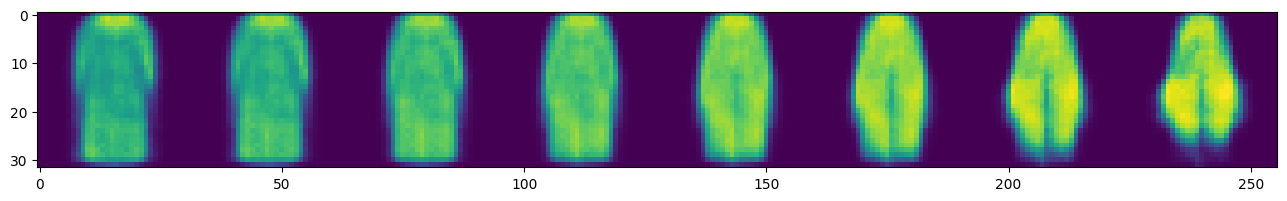

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 108.49it/s]


[Epoch: 22/40] [loss: 62.8283]


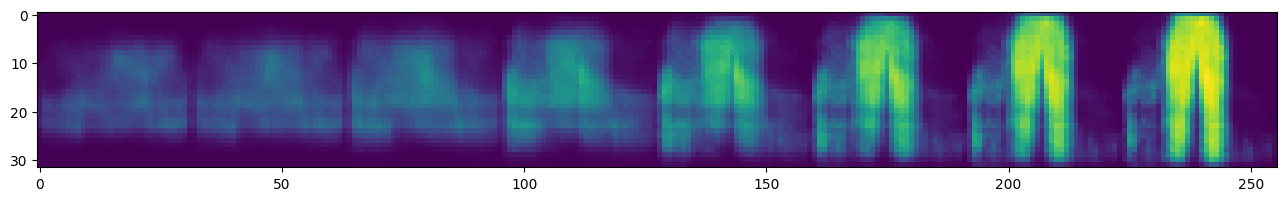

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 107.62it/s]

[Epoch: 23/40] [loss: 62.5747]


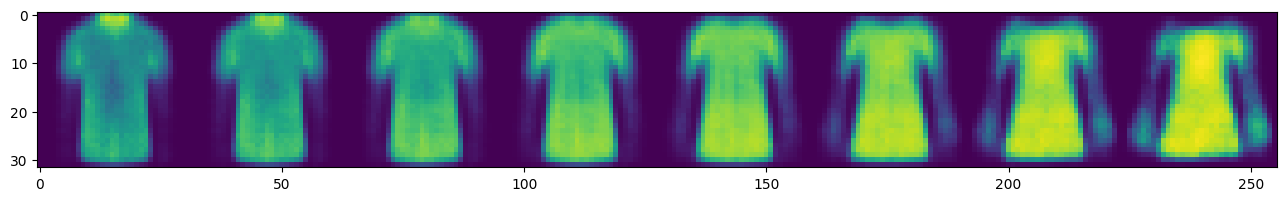

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 105.46it/s]


[Epoch: 24/40] [loss: 62.3571]


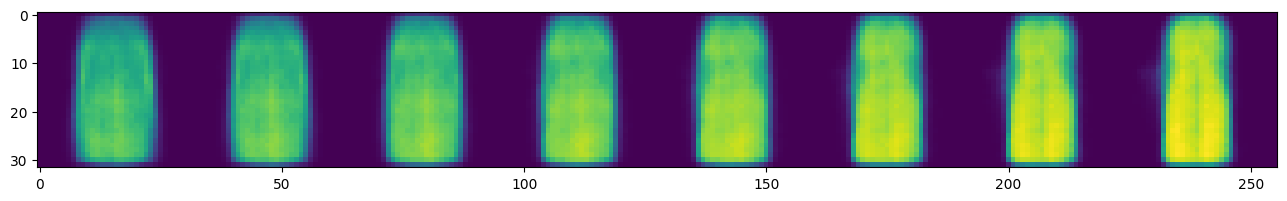

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 105.08it/s]


[Epoch: 25/40] [loss: 61.9665]


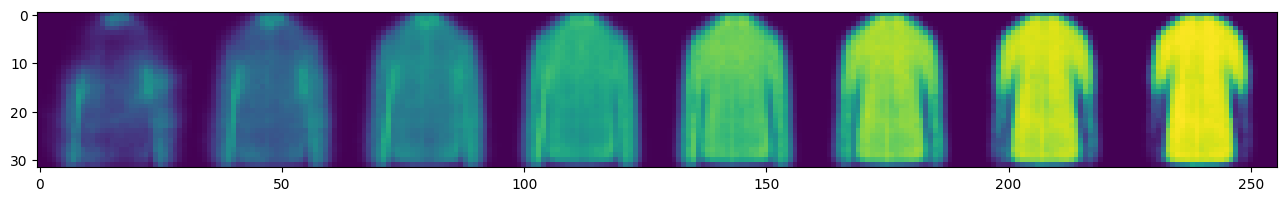

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 104.06it/s]

[Epoch: 26/40] [loss: 61.8642]


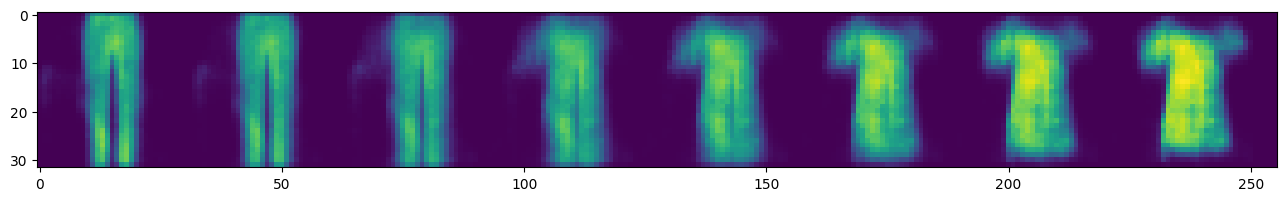

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 111.42it/s]

[Epoch: 27/40] [loss: 61.5452]


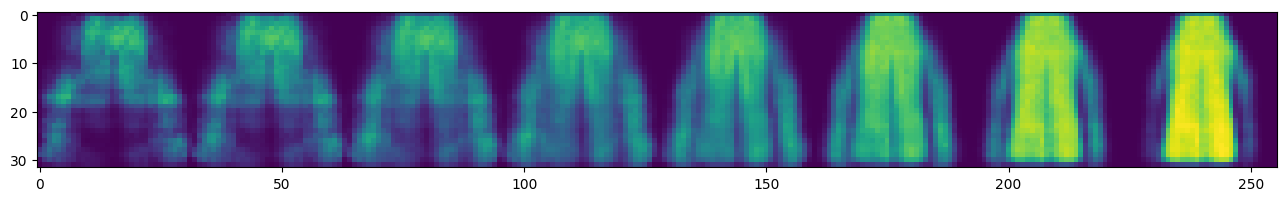

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 114.30it/s]

[Epoch: 28/40] [loss: 61.4566]


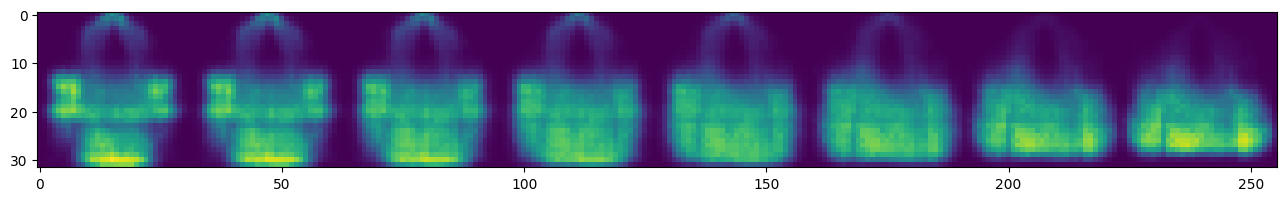

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 111.86it/s]


[Epoch: 29/40] [loss: 61.3289]


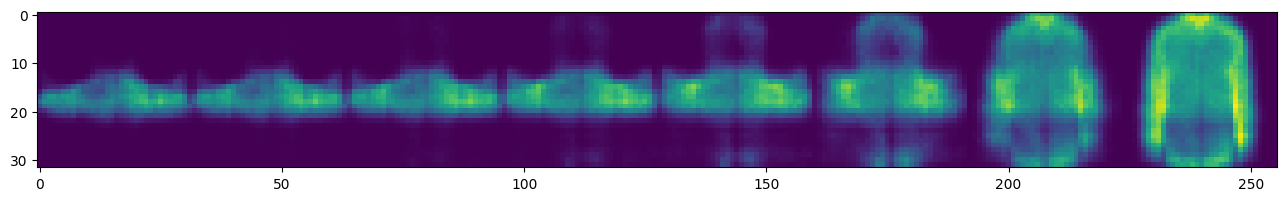

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 106.87it/s]

[Epoch: 30/40] [loss: 61.0551]


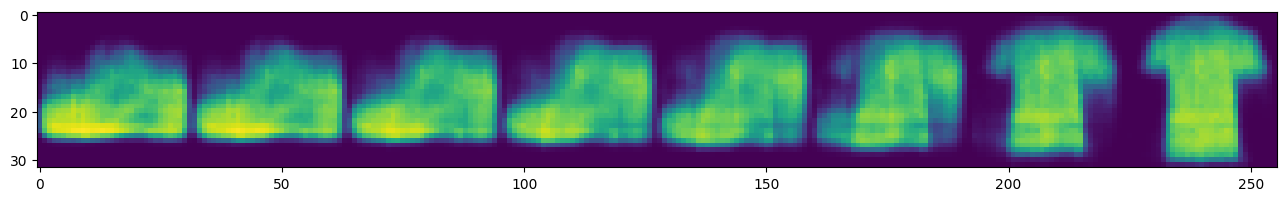

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 106.94it/s]

[Epoch: 31/40] [loss: 60.8496]


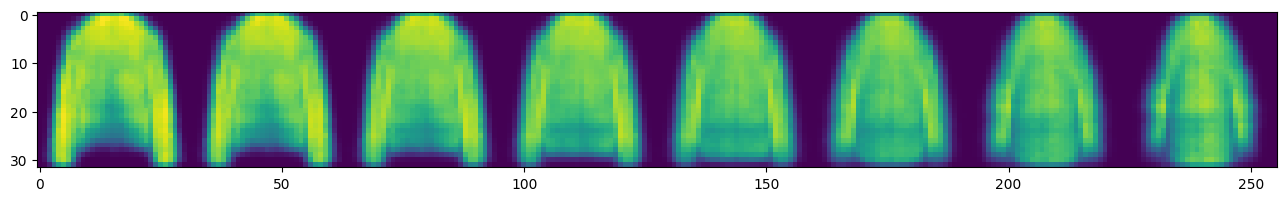

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 105.83it/s]


[Epoch: 32/40] [loss: 60.6773]


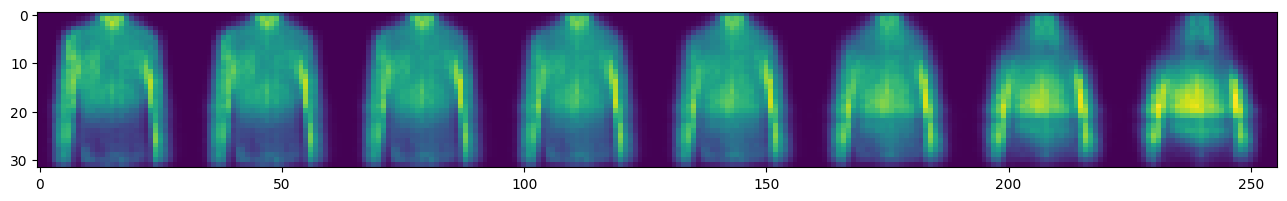

100%|████████████████████████████████████████| 937/937 [00:09<00:00, 104.00it/s]


[Epoch: 33/40] [loss: 60.6041]


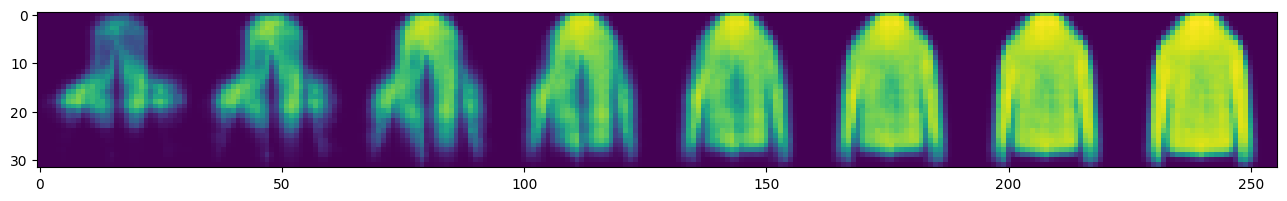

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 107.56it/s]

[Epoch: 34/40] [loss: 60.5050]


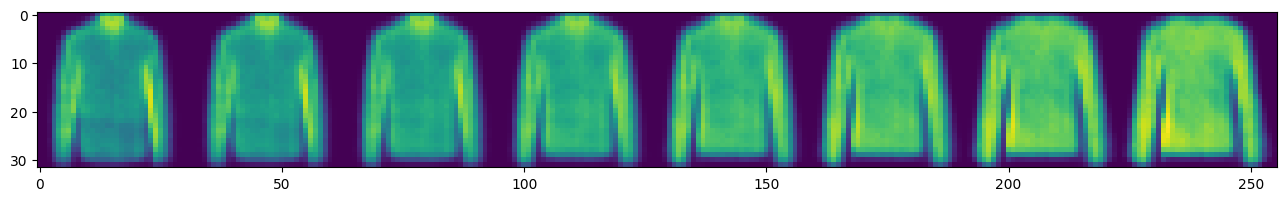

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 106.57it/s]


[Epoch: 35/40] [loss: 60.2923]


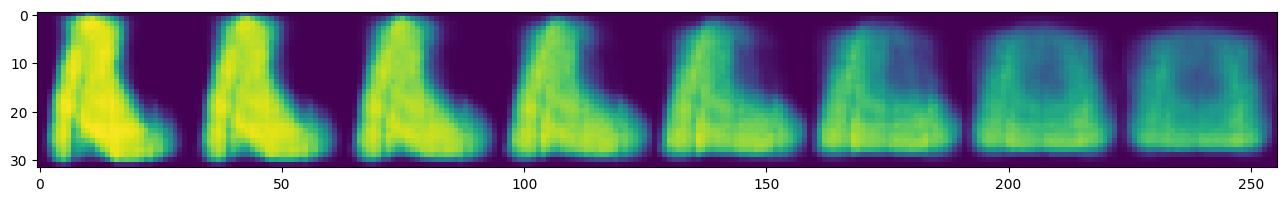

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 107.63it/s]


[Epoch: 36/40] [loss: 60.1093]


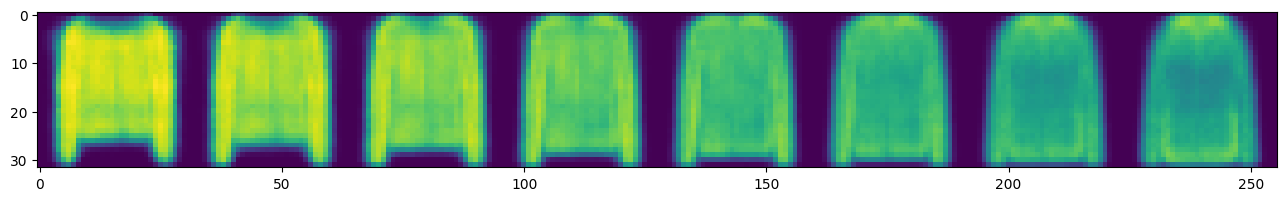

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 105.28it/s]

[Epoch: 37/40] [loss: 59.9444]


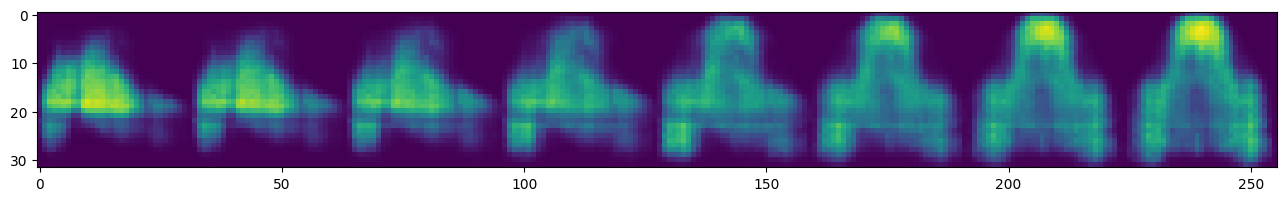

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 104.36it/s]

[Epoch: 38/40] [loss: 59.8060]


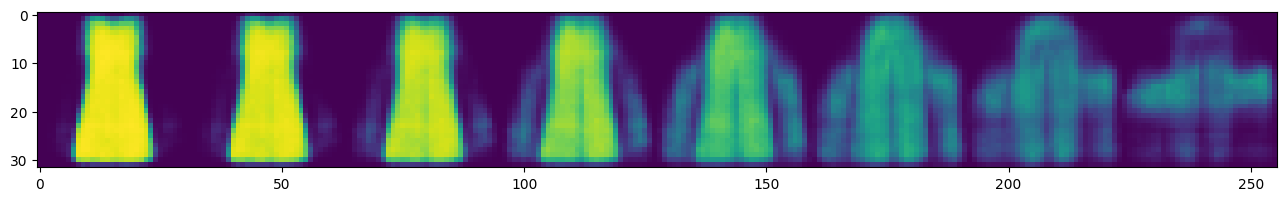

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 106.38it/s]


[Epoch: 39/40] [loss: 59.7965]


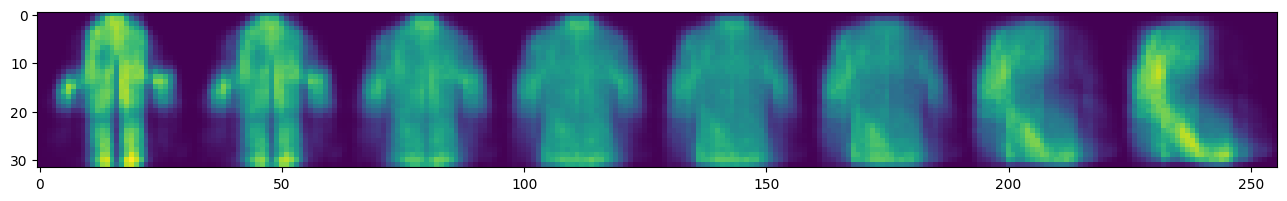

100%|████████████████████████████████████████| 937/937 [00:08<00:00, 106.38it/s]


[Epoch: 40/40] [loss: 59.6660]


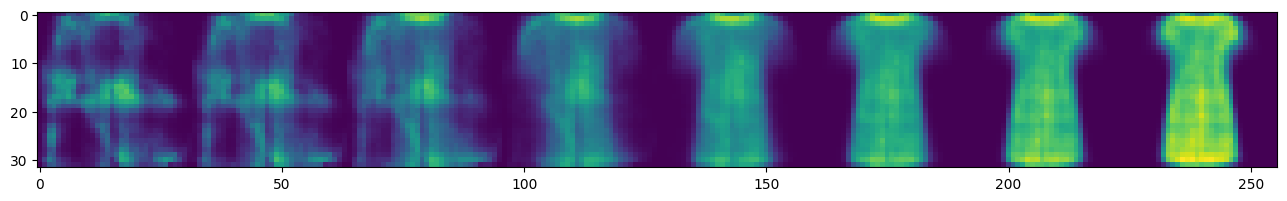

In [ ]:
vae = VAEManager(
    32 * 32,
    hidden_dim=256,
    latent_dim=64,
    lr=0.0002
)
vae_history = vae.train(dataloader, epochs=40)

### Visualize Loss

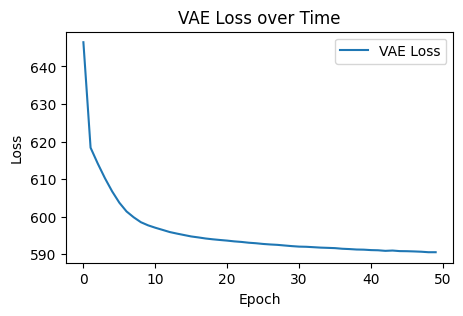

In [7]:
def plot_losses(vae_history):
    figsize = (5, 3)
    plt.figure(figsize=figsize)
    plt.plot(vae_history['loss'], label='VAE Loss')
    plt.title('VAE Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_losses(vae_history)